In [ ]:
!pip install torch_geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html
!pip install norse
!pip install networkx pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.3/785.3 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.6/217.6 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 74.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.8 MB/s eta 0:00:00
   ━━

In [ ]:
import pandas as pd

In [ ]:
data=pd.read_csv("/content/new_df.csv")

In [ ]:
set(data["insider"])

{0, 1}

Epoch 1: Train loss=0.1528, Val loss=0.1234
Epoch 2: Train loss=0.0731, Val loss=0.0422
Epoch 3: Train loss=0.0447, Val loss=0.0358
Epoch 4: Train loss=0.0395, Val loss=0.0350
Epoch 5: Train loss=0.0376, Val loss=0.0342
Epoch 6: Train loss=0.0361, Val loss=0.0336
Epoch 7: Train loss=0.0352, Val loss=0.0326
Epoch 8: Train loss=0.0336, Val loss=0.0314
Epoch 9: Train loss=0.0332, Val loss=0.0305
Epoch 10: Train loss=0.0316, Val loss=0.0303
Epoch 11: Train loss=0.0309, Val loss=0.0301
Epoch 12: Train loss=0.0300, Val loss=0.0298
Epoch 13: Train loss=0.0298, Val loss=0.0293
Epoch 14: Train loss=0.0292, Val loss=0.0285
Epoch 15: Train loss=0.0288, Val loss=0.0280
Epoch 16: Train loss=0.0286, Val loss=0.0276
Epoch 17: Train loss=0.0275, Val loss=0.0275
Epoch 18: Train loss=0.0268, Val loss=0.0277
Epoch 19: Train loss=0.0266, Val loss=0.0273
Epoch 20: Train loss=0.0255, Val loss=0.0266
Epoch 21: Train loss=0.0255, Val loss=0.0261
Epoch 22: Train loss=0.0243, Val loss=0.0256
Epoch 23: Train los

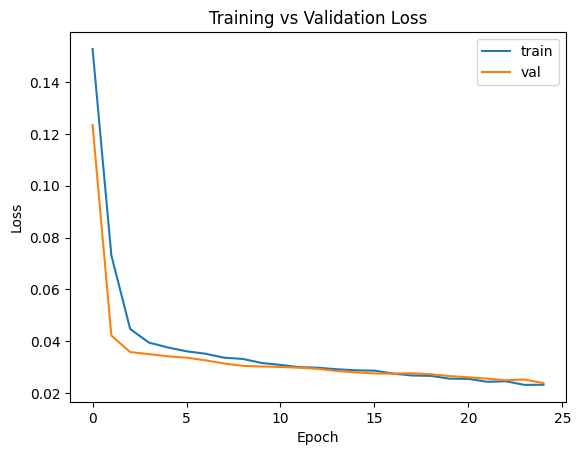

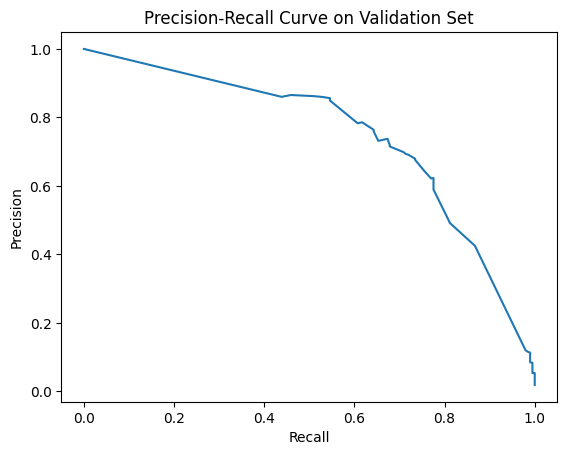

Best threshold based on validation F1: 0.544

Classification Report:
               precision    recall  f1-score   support

         0.0      0.995     0.992     0.994     10386
         1.0      0.650     0.750     0.697       196

    accuracy                          0.988     10582
   macro avg      0.823     0.871     0.845     10582
weighted avg      0.989     0.988     0.988     10582

Confusion Matrix:
 [[10307    79]
 [   49   147]]


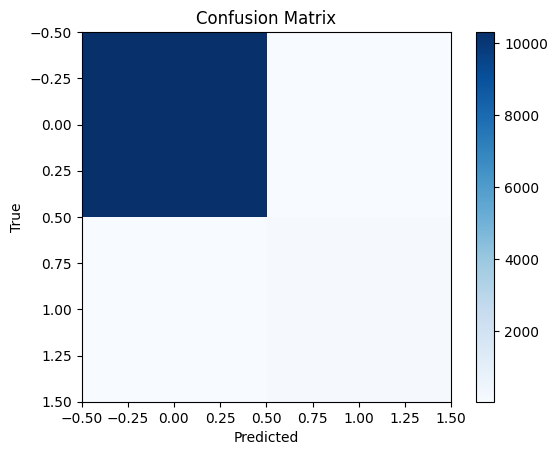

In [ ]:
# --------------------------- 1. Imports & dependencies -----------------------
import math, json, random, numpy as np, pandas as pd, torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
from norse.torch.module.lif import LIFCell

CSV_PATH = '/content/new_df.csv'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH = 256
EPOCHS = 25
LR = 0.001
# -----------------------------------------------------------------------------


# --------------------------- 2. Symbolic rules -------------------------------
formula_bank = [
    lambda x: (x[:, 0] > 0) & (x[:, 1] > 0),
    lambda x: x[:, 2] > 0,
    lambda x: (x[:, 3] > 0) & (x[:, 4] >= 3),
    lambda x: (x[:, 5] > 0) & (x[:, 6] > 0),
    lambda x: (x[:, 7] > 0) | (x[:, 8] > 0),
    lambda x: np.sum(x[:, 9:12] > 0, axis=1) >= 2,
    lambda x: x[:, 12] > 0,
    lambda x: (x[:, 13] > 0) & (x[:, 6] > 0),
    lambda x: (x[:, 14] == 1) & (x[:, 15] > 0),
    lambda x: x[:, 16] > 3,
]

def apply_formulas(x_np):
    features = []
    for rule in formula_bank:
        result = rule(x_np).astype(float)
        if not isinstance(result, np.ndarray):
             result = np.array([result] * x_np.shape[0], dtype=float)
        features.append(result)
    return np.stack(features, axis=1)
# -----------------------------------------------------------------------------


# --------------------------- 3. Dataset class -------------------------------
class UserDataset(Dataset):
    def __init__(self, df, scaler=None, fit=False):
        self.labels = df["insider"].values.astype("float32")
        X = df.drop(columns=["user", "insider"]).values.astype("float32")
        if fit: scaler.fit(X)
        X_scaled = scaler.transform(X)
        symbolic_feats = apply_formulas(X)
        self.X = np.concatenate([X_scaled, symbolic_feats], axis=1)
        self.scaler = scaler

    def __len__(self): return len(self.labels)
    def __getitem__(self, i): return self.X[i], self.labels[i]

df = pd.read_csv(CSV_PATH)
df = df[df['insider'].isin([0, 1])]

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["insider"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["insider"])

scaler = StandardScaler()
train_ds = UserDataset(train_df, scaler, fit=True)
val_ds = UserDataset(val_df, scaler)
test_ds = UserDataset(test_df, scaler)

train_dl = DataLoader(train_ds, BATCH, shuffle=True)
val_dl = DataLoader(val_ds, BATCH)
# -----------------------------------------------------------------------------


# --------------------------- 4. Graph utility -------------------------------
def create_similarity_graph(xb, threshold=0.9):
    sim = cosine_similarity(xb.cpu().numpy())
    G = nx.Graph()
    G.add_nodes_from(range(len(xb)))
    for i in range(len(xb)):
        for j in range(i + 1, len(xb)):
            if sim[i, j] > threshold:
                G.add_edge(i, j)
    return from_networkx(G).to(DEVICE)
# -----------------------------------------------------------------------------


# --------------------------- 5. Spiking GNN model ---------------------------
class SpikingGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_p=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.spike1 = LIFCell()
        self.dropout1 = nn.Dropout(dropout_p)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.spike2 = LIFCell()
        self.dropout2 = nn.Dropout(dropout_p)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x, _ = self.spike1(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        x, _ = self.spike2(x)
        x = self.dropout2(x)
        x = self.conv3(x, edge_index)
        return x
# -----------------------------------------------------------------------------


# ----------------------- 6. Focal Loss Implementation -----------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
# -----------------------------------------------------------------------------

# --------------------------- 7. Model, optimizer, loss ----------------------
model = SpikingGNN(
    in_channels=train_ds.X.shape[1],
    hidden_channels=64,
    out_channels=2,
    dropout_p=0.3
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ✅ Manually tuned weights: 1.0 for normal, 2.5 for insiders
class_weights = torch.tensor([1.0, 2.5], dtype=torch.float).to(DEVICE)

criterion = FocalLoss(gamma=2, weight=class_weights)

# -----------------------------------------------------------------------------


# --------------------------- 8. Training loop -------------------------------
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience, counter = 7, 0  # More patience for focal loss

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.clone().detach().to(DEVICE).float(), yb.long().to(DEVICE)
        data = create_similarity_graph(xb)
        data.x = xb
        out = model(data)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_dl))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.clone().detach().to(DEVICE).float(), yb.long().to(DEVICE)
            data = create_similarity_graph(xb)
            data.x = xb
            out = model(data)
            loss = criterion(out, yb)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dl))

    print(f"Epoch {epoch+1}: Train loss={train_losses[-1]:.4f}, Val loss={val_losses[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter = 0
        torch.save(model.state_dict(), "best_model1.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Plot losses
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()
# -----------------------------------------------------------------------------


# --------------------- 9. Threshold tuning & Evaluation ----------------------
def get_val_predictions(model, val_dl):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.clone().detach().to(DEVICE).float()
            data = create_similarity_graph(xb)
            data.x = xb
            logits = model(data)
            probs = torch.softmax(logits, dim=1)[:, 1]  # prob of class 1
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(yb.numpy())
    return np.array(all_probs), np.array(all_labels)

val_probs, val_labels = get_val_predictions(model, val_dl)

precision, recall, thresholds = precision_recall_curve(val_labels, val_probs)

# Plot Precision-Recall Curve
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve on Validation Set")
plt.show()

# Find best threshold (max F1)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold based on validation F1: {best_threshold:.3f}")

# Evaluate on Test set with best threshold
test_dl = DataLoader(test_ds, BATCH)
model.load_state_dict(torch.load("best_model1.pt"))
model.eval()
preds, y_true = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.clone().detach().to(DEVICE).float()
        data = create_similarity_graph(xb)
        data.x = xb
        logits = model(data)
        probs = torch.softmax(logits, dim=1)[:, 1]
        batch_preds = (probs > best_threshold).long().cpu().numpy()
        preds.extend(batch_preds)
        y_true.extend(yb.numpy())

print("\nClassification Report:\n", classification_report(y_true, preds, digits=3))

cm = confusion_matrix(y_true, preds)

# ✅ Print matrix values before plotting
print("Confusion Matrix:\n", cm)

plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5t

Epoch 1: Train loss=0.1525, Val loss=0.1232
Epoch 2: Train loss=0.0790, Val loss=0.0445
Epoch 3: Train loss=0.0453, Val loss=0.0371
Epoch 4: Train loss=0.0398, Val loss=0.0340
Epoch 5: Train loss=0.0376, Val loss=0.0338
Epoch 6: Train loss=0.0364, Val loss=0.0333
Epoch 7: Train loss=0.0350, Val loss=0.0330
Epoch 8: Train loss=0.0335, Val loss=0.0319
Epoch 9: Train loss=0.0329, Val loss=0.0307
Epoch 10: Train loss=0.0321, Val loss=0.0305
Epoch 11: Train loss=0.0311, Val loss=0.0300
Epoch 12: Train loss=0.0307, Val loss=0.0295
Epoch 13: Train loss=0.0297, Val loss=0.0292
Epoch 14: Train loss=0.0291, Val loss=0.0287
Epoch 15: Train loss=0.0287, Val loss=0.0283
Epoch 16: Train loss=0.0275, Val loss=0.0282
Epoch 17: Train loss=0.0267, Val loss=0.0282
Epoch 18: Train loss=0.0269, Val loss=0.0274
Epoch 19: Train loss=0.0261, Val loss=0.0268
Epoch 20: Train loss=0.0257, Val loss=0.0266
Epoch 21: Train loss=0.0252, Val loss=0.0259
Epoch 22: Train loss=0.0242, Val loss=0.0258
Epoch 23: Train los

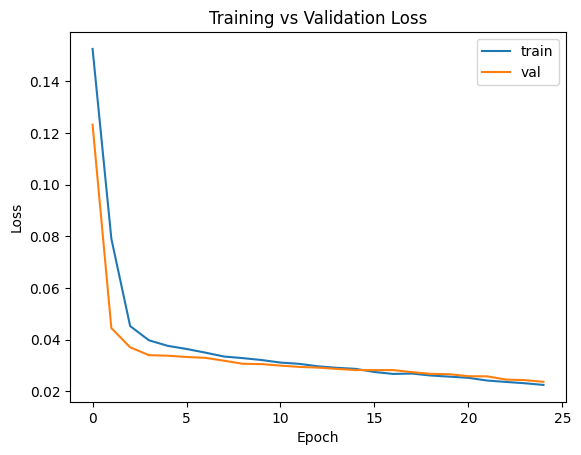

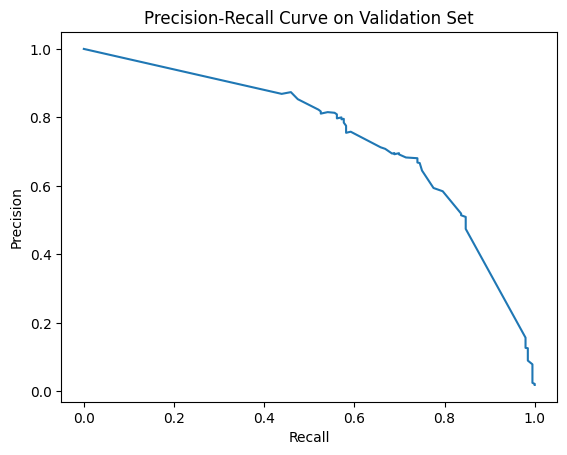

Best threshold based on validation F1: 0.566

Classification Report:
               precision    recall  f1-score   support

         0.0      0.995     0.992     0.993     10386
         1.0      0.628     0.724     0.673       196

    accuracy                          0.987     10582
   macro avg      0.812     0.858     0.833     10582
weighted avg      0.988     0.987     0.987     10582

Confusion Matrix:
 [[10302    84]
 [   54   142]]


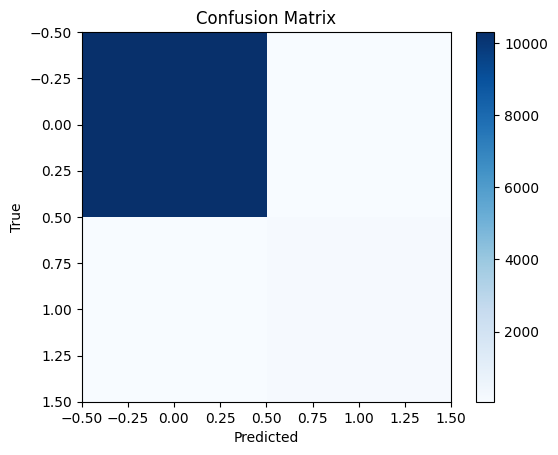

In [ ]:
# --------------------------- 1. Imports & dependencies -----------------------
import math, json, random, numpy as np, pandas as pd, torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
from norse.torch.module.lif import LIFCell

CSV_PATH = '/content/new_df.csv'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH = 256
EPOCHS = 25
LR = 0.001
# -----------------------------------------------------------------------------


# --------------------------- 2. Symbolic rules -------------------------------
formula_bank = [
    lambda x: (x[:, 0] > 0) & (x[:, 1] > 0),
    lambda x: x[:, 2] > 0,
    lambda x: (x[:, 3] > 0) & (x[:, 4] >= 3),
    lambda x: (x[:, 5] > 0) & (x[:, 6] > 0),
    lambda x: (x[:, 7] > 0) | (x[:, 8] > 0),
    lambda x: np.sum(x[:, 9:12] > 0, axis=1) >= 2,
    lambda x: x[:, 12] > 0,
    lambda x: (x[:, 13] > 0) & (x[:, 6] > 0),
    lambda x: (x[:, 14] == 1) & (x[:, 15] > 0),
    lambda x: x[:, 16] > 3,
]

def apply_formulas(x_np):
    features = []
    for rule in formula_bank:
        result = rule(x_np).astype(float)
        if not isinstance(result, np.ndarray):
             result = np.array([result] * x_np.shape[0], dtype=float)
        features.append(result)
    return np.stack(features, axis=1)
# -----------------------------------------------------------------------------


# --------------------------- 3. Dataset class -------------------------------
class UserDataset(Dataset):
    def __init__(self, df, scaler=None, fit=False):
        self.labels = df["insider"].values.astype("float32")
        X = df.drop(columns=["user", "insider"]).values.astype("float32")
        if fit: scaler.fit(X)
        X_scaled = scaler.transform(X)
        symbolic_feats = apply_formulas(X)
        self.X = np.concatenate([X_scaled, symbolic_feats], axis=1)
        self.scaler = scaler

    def __len__(self): return len(self.labels)
    def __getitem__(self, i): return self.X[i], self.labels[i]

df = pd.read_csv(CSV_PATH)
df = df[df['insider'].isin([0, 1])]

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["insider"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["insider"])

scaler = StandardScaler()
train_ds = UserDataset(train_df, scaler, fit=True)
val_ds = UserDataset(val_df, scaler)
test_ds = UserDataset(test_df, scaler)

train_dl = DataLoader(train_ds, BATCH, shuffle=True)
val_dl = DataLoader(val_ds, BATCH)
# -----------------------------------------------------------------------------


# --------------------------- 4. Graph utility -------------------------------
def create_similarity_graph(xb, threshold=0.9):
    sim = cosine_similarity(xb.cpu().numpy())
    G = nx.Graph()
    G.add_nodes_from(range(len(xb)))
    for i in range(len(xb)):
        for j in range(i + 1, len(xb)):
            if sim[i, j] > threshold:
                G.add_edge(i, j)
    return from_networkx(G).to(DEVICE)
# -----------------------------------------------------------------------------


# --------------------------- 5. Spiking GNN model ---------------------------
class SpikingGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_p=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.spike1 = LIFCell()
        self.dropout1 = nn.Dropout(dropout_p)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.spike2 = LIFCell()
        self.dropout2 = nn.Dropout(dropout_p)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x, _ = self.spike1(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        x, _ = self.spike2(x)
        x = self.dropout2(x)
        x = self.conv3(x, edge_index)
        return x
# -----------------------------------------------------------------------------


# ----------------------- 6. Focal Loss Implementation -----------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
# -----------------------------------------------------------------------------

# --------------------------- 7. Model, optimizer, loss ----------------------
model = SpikingGNN(
    in_channels=train_ds.X.shape[1],
    hidden_channels=64,
    out_channels=2,
    dropout_p=0.3
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ✅ Manually tuned weights: 1.0 for normal, 2.5 for insiders
class_weights = torch.tensor([1.0, 2.5], dtype=torch.float).to(DEVICE)

criterion = FocalLoss(gamma=2, weight=class_weights)

# -----------------------------------------------------------------------------


# --------------------------- 8. Training loop -------------------------------
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience, counter = 7, 0  # More patience for focal loss

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.clone().detach().to(DEVICE).float(), yb.long().to(DEVICE)
        data = create_similarity_graph(xb)
        data.x = xb
        out = model(data)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_dl))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.clone().detach().to(DEVICE).float(), yb.long().to(DEVICE)
            data = create_similarity_graph(xb)
            data.x = xb
            out = model(data)
            loss = criterion(out, yb)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dl))

    print(f"Epoch {epoch+1}: Train loss={train_losses[-1]:.4f}, Val loss={val_losses[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter = 0
        torch.save(model.state_dict(), "best_model1.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Plot losses
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()
# -----------------------------------------------------------------------------


# --------------------- 9. Threshold tuning & Evaluation ----------------------
def get_val_predictions(model, val_dl):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.clone().detach().to(DEVICE).float()
            data = create_similarity_graph(xb)
            data.x = xb
            logits = model(data)
            probs = torch.softmax(logits, dim=1)[:, 1]  # prob of class 1
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(yb.numpy())
    return np.array(all_probs), np.array(all_labels)

val_probs, val_labels = get_val_predictions(model, val_dl)

precision, recall, thresholds = precision_recall_curve(val_labels, val_probs)

# Plot Precision-Recall Curve
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve on Validation Set")
plt.show()

# Find best threshold (max F1)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold based on validation F1: {best_threshold:.3f}")

# Evaluate on Test set with best threshold
test_dl = DataLoader(test_ds, BATCH)
model.load_state_dict(torch.load("best_model1.pt"))
model.eval()
preds, y_true = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.clone().detach().to(DEVICE).float()
        data = create_similarity_graph(xb)
        data.x = xb
        logits = model(data)
        probs = torch.softmax(logits, dim=1)[:, 1]
        batch_preds = (probs > best_threshold).long().cpu().numpy()
        preds.extend(batch_preds)
        y_true.extend(yb.numpy())

print("\nClassification Report:\n", classification_report(y_true, preds, digits=3))

cm = confusion_matrix(y_true, preds)

# ✅ Print matrix values before plotting
print("Confusion Matrix:\n", cm)

plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


Balanced test set class distribution:
insider
0    196
1    196
Name: count, dtype: int64

Tuning threshold to balance False Positives and False Negatives:
Threshold: 0.30 | TN: 184 | FP: 12 | FN: 7 | TP: 189 | Recall: 0.964 | Precision: 0.940
Threshold: 0.35 | TN: 184 | FP: 12 | FN: 7 | TP: 189 | Recall: 0.964 | Precision: 0.940
Threshold: 0.40 | TN: 192 | FP: 4 | FN: 39 | TP: 157 | Recall: 0.801 | Precision: 0.975
Threshold: 0.45 | TN: 192 | FP: 4 | FN: 40 | TP: 156 | Recall: 0.796 | Precision: 0.975
Threshold: 0.50 | TN: 194 | FP: 2 | FN: 42 | TP: 154 | Recall: 0.786 | Precision: 0.987
Threshold: 0.55 | TN: 194 | FP: 2 | FN: 43 | TP: 153 | Recall: 0.781 | Precision: 0.987
Threshold: 0.60 | TN: 194 | FP: 2 | FN: 44 | TP: 152 | Recall: 0.776 | Precision: 0.987
Threshold: 0.65 | TN: 195 | FP: 1 | FN: 48 | TP: 148 | Recall: 0.755 | Precision: 0.993
Threshold: 0.70 | TN: 196 | FP: 0 | FN: 48 | TP: 148 | Recall: 0.755 | Precision: 1.000

Selected best threshold: 0.30


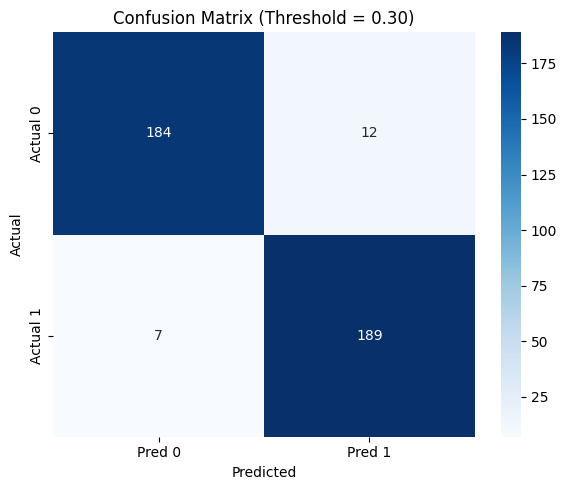


Classification Report (Balanced Test Set):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       196
           1       0.94      0.96      0.95       196

    accuracy                           0.95       392
   macro avg       0.95      0.95      0.95       392
weighted avg       0.95      0.95      0.95       392

AUC (Balanced Test Set): 0.9896


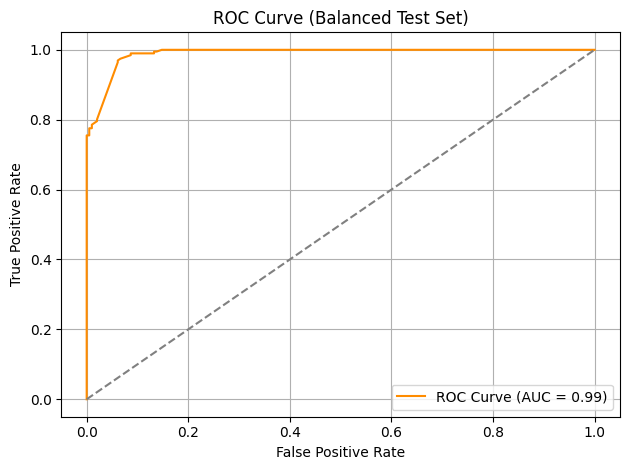

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torch.utils.data import DataLoader

# ----- STEP 1: Prepare balanced test set with 196 zeros and 196 ones -----
actual_0 = test_df[test_df['insider'] == 0].copy()
actual_1 = test_df[test_df['insider'] == 1].copy()

n_samples = 196  # fixed sample size for both classes as you want
actual_0_down = actual_0.sample(n=n_samples, random_state=42)
actual_1_down = actual_1.sample(n=n_samples, random_state=42)
balanced_df = pd.concat([actual_0_down, actual_1_down], ignore_index=True).sample(frac=1, random_state=42)

print("Balanced test set class distribution:")
print(balanced_df['insider'].value_counts())

# ----- STEP 2: Create Dataset and DataLoader -----
reduced_test_dataset = UserDataset(balanced_df, scaler=scaler, fit=False)  # scaler fitted before
reduced_test_loader = DataLoader(reduced_test_dataset, batch_size=BATCH)

# ----- STEP 3: Inference -----
model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for xb, yb in reduced_test_loader:
        xb, yb = xb.to(DEVICE).float(), yb.long().to(DEVICE)

        data = create_similarity_graph(xb)
        data.x = xb

        logits = model(data)
        all_logits.append(logits.cpu())
        all_labels.append(yb.cpu())

all_logits = torch.cat(all_logits)
all_labels = torch.cat(all_labels)

# ----- STEP 4: Calculate probabilities for class 1 -----
probs = torch.softmax(all_logits, dim=1)[:, 1]

# ----- STEP 5: Threshold tuning around your confusion matrix -----
thresholds = np.linspace(0.3, 0.7, 9)  # tuning thresholds from 0.3 to 0.7

print("\nTuning threshold to balance False Positives and False Negatives:")
for th in thresholds:
    preds_th = (probs > th).long()
    cm_th = confusion_matrix(all_labels.numpy(), preds_th.numpy())
    tn, fp, fn, tp = cm_th.ravel()
    recall = tp / (tp + fn + 1e-8)
    precision = tp / (tp + fp + 1e-8)
    print(f"Threshold: {th:.2f} | TN: {tn} | FP: {fp} | FN: {fn} | TP: {tp} | Recall: {recall:.3f} | Precision: {precision:.3f}")

# Select threshold with lowest FP while keeping FN very low (customize as needed)
# Example: lowest FN threshold (or you pick by looking at the output)
best_idx = np.argmin([confusion_matrix(all_labels.numpy(), (probs > t).long()).ravel()[2] for t in thresholds])
best_threshold = thresholds[best_idx]
print(f"\nSelected best threshold: {best_threshold:.2f}")

# ----- STEP 6: Final predictions with selected threshold -----
final_preds = (probs > best_threshold).long()

# ----- STEP 7: Display confusion matrix and classification report -----
cm_final = confusion_matrix(all_labels.numpy(), final_preds.numpy())
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title(f"Confusion Matrix (Threshold = {best_threshold:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\nClassification Report (Balanced Test Set):")
print(classification_report(all_labels.numpy(), final_preds.numpy()))

# ----- STEP 8: ROC Curve and AUC -----
fpr, tpr, _ = roc_curve(all_labels.numpy(), probs.numpy())
roc_auc = auc(fpr, tpr)
print(f"AUC (Balanced Test Set): {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Balanced Test Set)")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()
